In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.backcompat import keepdim_warning
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
random.seed(2147483647)
random.shuffle(words)
n = len(words)

n_train = int(0.8 * n)
n_dev = int(0.1 * n)

words_train = words[:n_train]
words_dev = words[n_train:n_train + n_dev]
words_test = words[n_train + n_dev:]

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

In [13]:
def build_xy(words, stoi, block_size=3):
    x, y = [], []
    for w in words[:]:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X, Y = torch.tensor(x), torch.tensor(y)
    return X, Y

def data_nll(x, y, C, W1, W2, B2, bngain, bnbias, bnmean_running, bnstd_running, smoothing=0.05, eps=1e-5):
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * ((hpreact - bnmean_running) / (bnstd_running ** 2 + eps) ** 0.5) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    return F.cross_entropy(logits, y, label_smoothing=smoothing).item()

def train_step(x, y, C, W1, W2, B2, parameters, bngain, bnbias, bnmean_running, bnstd_running, lr1=0.1, lr2=None, steps=10, batch_size=32):
    lossi = []
    for i in range(steps):
        ix = torch.randint(0, x.shape[0], (batch_size,))
        xb, yb = x[ix], y[ix]
        emb = C[xb]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)
        hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias

        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

        h = torch.tanh(hpreact)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, yb)
        for p in parameters:
            p.grad = None
        loss.backward()
        lr = lr1 if lr2 is None or i > 10000 else lr2
        with torch.no_grad():
            for p in parameters:
                p.data += -lr * p.grad
        lossi.append(loss.item())
        if i % 1000 == 0:
            print(f"Step {i}, Loss: {loss.item()}")
    return lossi, bnmean_running, bnstd_running

def generate(C, W1, W2, B2, bngain, bnbias, bnmean_running, bnstd_running, itos, block_size=3, seed=2147483647, num_samples=5, eps=1e-5):
    g = torch.Generator().manual_seed(seed)
    for _ in range(num_samples):
        out = []
        context = [0] * block_size
        while True:
            ctx = torch.tensor(context)
            emb = C[ctx]
            embcat = emb.view(1, -1)
            hpreact = embcat @ W1
            hpreact = bngain * ((hpreact - bnmean_running) / (bnstd_running ** 2 + eps) ** 0.5) + bnbias
            h = torch.tanh(hpreact)
            logits = h @ W2 + B2
            p = logits.squeeze(0).softmax(dim=0)
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix]
            if ix == 0:
                break
            else:
                out.append(ix)
        print(''.join(itos[i] for i in out))

In [4]:
x_tr, y_tr = build_xy(words_train, stoi)
x_dev, y_dev = build_xy(words_dev, stoi)
x_te, y_te = build_xy(words_test, stoi)

In [5]:
n_emb = 10
n_hidden = 200
block_size = 3
fan_in = n_emb * block_size

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                generator=g)
W1 = torch.randn((fan_in, n_hidden),    generator=g) * (5 / 3) / (fan_in + n_hidden) ** 0.5
#B1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
B2 = torch.randn(vocab_size,                        generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, B2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

ix = torch.randint(0, x_tr.shape[0], (32,))
xb, yb = x_tr[ix], y_tr[ix]
emb = C[xb]
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1
h = torch.tanh(hpreact)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, yb)
print(loss.item())

12097
3.2899913787841797


(array([ 14.,  27.,  32.,  77.,  83.,  75.,  97., 109., 127., 143., 118.,
        137., 142., 139., 163., 173., 141., 150., 135., 157., 191., 175.,
        177., 185., 175., 142., 196., 163., 170., 165., 160., 148., 160.,
        158., 149., 169., 148., 166., 169., 135., 147., 141., 113., 101.,
        101.,  88.,  67.,  50.,  34.,  18.]),
 array([-0.97529256, -0.9361553 , -0.89701805, -0.85788079, -0.81874353,
        -0.77960627, -0.74046901, -0.70133175, -0.6621945 , -0.62305724,
        -0.58391998, -0.54478272, -0.50564546, -0.4665082 , -0.42737094,
        -0.38823369, -0.34909643, -0.30995917, -0.27082191, -0.23168465,
        -0.19254739, -0.15341013, -0.11427288, -0.07513562, -0.03599836,
         0.0031389 ,  0.04227616,  0.08141342,  0.12055068,  0.15968793,
         0.19882519,  0.23796245,  0.27709971,  0.31623697,  0.35537423,
         0.39451149,  0.43364874,  0.472786  ,  0.51192326,  0.55106052,
         0.59019778,  0.62933504,  0.66847229,  0.70760955,  0.74674681,
 

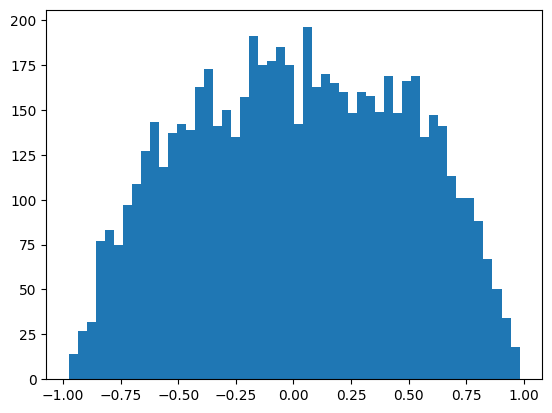

In [6]:
plt.hist(h.view(-1).tolist(), 50)

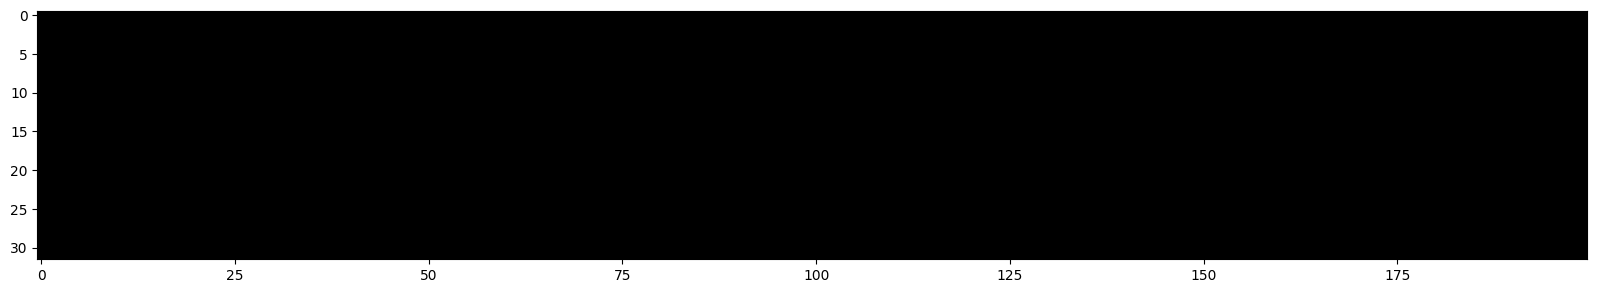

In [7]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [11]:
lossi_tr, bnmean_running, bnstd_running = train_step(x_tr, y_tr, C, W1, W2, B2, parameters, bngain, bnbias, bnmean_running, bnstd_running, 0.1, 0.01, 100000, batch_size=128)

Step 0, Loss: 2.065232992172241
Step 1000, Loss: 2.1163413524627686
Step 2000, Loss: 1.9083670377731323
Step 3000, Loss: 2.057676076889038
Step 4000, Loss: 2.1777937412261963
Step 5000, Loss: 2.1640491485595703
Step 6000, Loss: 2.097494125366211
Step 7000, Loss: 2.1100919246673584
Step 8000, Loss: 1.9735642671585083
Step 9000, Loss: 2.088982343673706
Step 10000, Loss: 1.9987491369247437
Step 11000, Loss: 1.8947741985321045
Step 12000, Loss: 1.913456678390503
Step 13000, Loss: 2.0095787048339844
Step 14000, Loss: 2.0499422550201416
Step 15000, Loss: 1.8393901586532593
Step 16000, Loss: 2.0674452781677246
Step 17000, Loss: 2.0355732440948486
Step 18000, Loss: 1.9902844429016113
Step 19000, Loss: 2.056243658065796
Step 20000, Loss: 2.0741970539093018
Step 21000, Loss: 2.103822946548462
Step 22000, Loss: 2.0187435150146484
Step 23000, Loss: 2.2288501262664795
Step 24000, Loss: 1.9764504432678223
Step 25000, Loss: 2.111845016479492
Step 26000, Loss: 2.1458356380462646
Step 27000, Loss: 2.15

In [12]:
print(data_nll(x_tr, y_tr, C, W1, W2, B2, bngain, bnbias, bnmean_running, bnstd_running))
print(data_nll(x_dev, y_dev, C, W1, W2, B2, bngain, bnbias, bnmean_running, bnstd_running))

2.218135118484497
2.300053358078003


In [14]:
generate(C, W1, W2, B2, bngain, bnbias, bnmean_running, bnstd_running, itos)

celi
aleah
makilah
tyha
lolivitta
